In [ ]:
!pip install nlp
!pip install transformers
!pip install sentencepiece
!pip install simpletransformers
!pip install umap-learn

In [ ]:
import torch
import transformers
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Tesi/

/content/drive/MyDrive/Tesi


In [ ]:
f = open('gov_uk_10000.json',) 
df = pd.read_json(f)
df = df[0:1000]

In [ ]:
from transformers import T5Model, T5Tokenizer, T5EncoderModel, T5TokenizerFast, T5ForConditionalGeneration

tokenizer = T5TokenizerFast.from_pretrained('t5-base')
model_predict = T5ForConditionalGeneration.from_pretrained('t5-base', output_hidden_states = True)

In [ ]:
texts = df['text'] + "</s>"
texts = texts.tolist()

In [ ]:
input_ids = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).input_ids
tokens = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

In [ ]:
input_ids.shape

torch.Size([1000, 512])

In [ ]:
model_encode = T5EncoderModel.from_pretrained('outputs', output_hidden_states = True)

batch_size = 100    
output = []

for i in range(0, len(df), batch_size):
  with torch.no_grad():    
    result = model_encode(input_ids=input_ids[i:i+batch_size]).last_hidden_state
    output.append(result)

token_embeddings = torch.cat(output)
token_embeddings.shape

Some weights of the model checkpoint at outputs were not used when initializing T5EncoderModel: ['decoder.embed_tokens.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.q.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.v.weight', 'de

torch.Size([1000, 512, 512])

In [ ]:
torch.save(token_embeddings, 'token_embeddings_1000.pt') 

In [ ]:
token_embeddings = torch.load('token_embeddings_1000.pt')

In [ ]:
documents_embeddings = torch.mean(token_embeddings, dim=1)
documents_embeddings.shape

torch.Size([1000, 512])

In [ ]:
import umap.umap_ as umap
import numpy as np
umap_model = umap.UMAP(n_neighbors=15, n_components=15, metric='cosine')
documents_embedding_reduced = umap_model.fit_transform(documents_embeddings)

In [ ]:
documents_embedding_reduced.shape

(1000, 10)

In [ ]:
!pip install hdbscan

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom').fit(documents_embedding_reduced)
df['cluster_label'] = cluster.labels_
df

,date,title,link,text,cluster_label
0,2020-12-10,Russia’s ongoing aggression against Ukraine an...,https://www.gov.uk/government/speeches/russias...,Thank you Mr Chair. We share the concerns expr...,10
1,2020-12-10,Highways England – helping you this Christmas,https://www.gov.uk/government/news/highways-en...,Some 778 miles of roadworks on England’s motor...,-1
2,2020-12-10,UK announces travel bans and asset freezes for...,https://www.gov.uk/government/news/uk-announce...,Today (10 December) the UK has announced a thi...,10
3,2020-12-10,Science Minister at the Universities UK Resear...,https://www.gov.uk/government/speeches/science...,"Thank you for that welcome, and for inviting m...",7
4,2020-12-10,Company fined for illegally depositing waste i...,https://www.gov.uk/government/news/company-fin...,Appearing at Teesside Magistrates’ Court on Mo...,11
...,...,...,...,...,...
995,2020-11-10,A letter from Rishi Sunak to Sir David Norgrov...,https://www.gov.uk/government/publications/a-l...,"Today, the Chancellor has written to the Chair...",1
996,2020-11-10,More rapid COVID-19 tests to be rolled out acr...,https://www.gov.uk/government/news/more-rapid-...,Over half a million rapid-turnaround lateral f...,20
997,2020-11-09,Communities at risk of flooding urged to apply...,https://www.gov.uk/government/news/communities...,A transformative £200m programme to improve th...,15
998,2020-11-08,Social media giants agree package of measures ...,https://www.gov.uk/government/news/social-medi...,Digital Secretary Oliver Dowden and Health Sec...,23


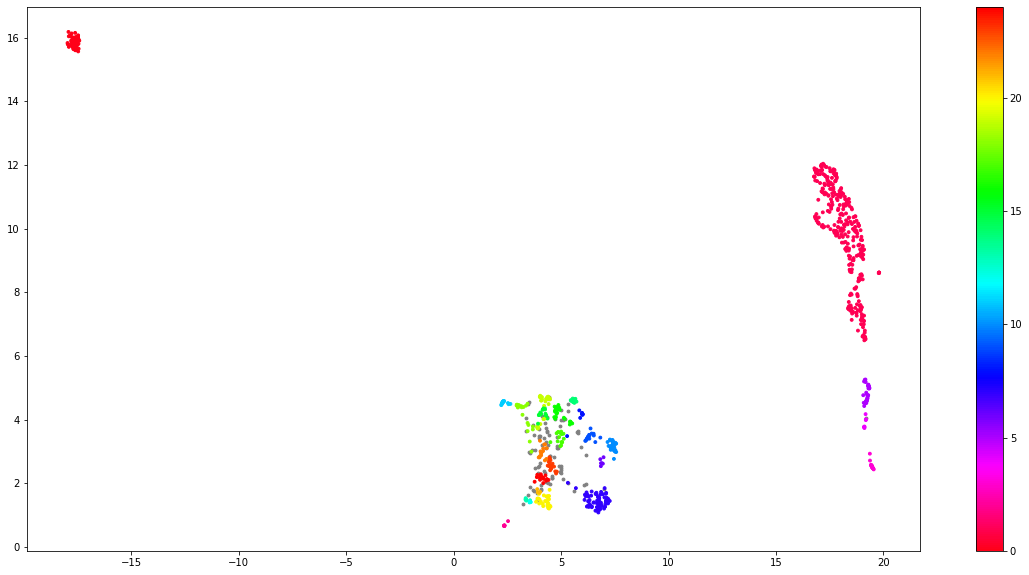

In [ ]:
import matplotlib.pyplot as plt

umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(documents_embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='grey', s=8)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=8, cmap='hsv_r')
plt.colorbar()

## CTFIDF 

In [ ]:
dataset2 = pd.DataFrame(df, columns=["text"])
dataset2['topic'] = cluster.labels_
dataset2['Doc_ID'] = range(len(dataset2))
docs_per_topic = dataset2.groupby(['topic'], as_index = False).agg({'text': ' '.join})

In [ ]:
docs_per_topic

,topic,text
0,-1,Some 778 miles of roadworks on England’s motor...
1,0,...
2,1,Ofqual is seeking views about advance informat...
3,2,Each IFCA needs members who will take a balanc...
4,3,OPRED communications issued to stakeholders in...
5,4,These letters provide notice to independent sc...
6,5,These are the newsletters sent out by the ASRU...
7,6,The Court of Appeal has today agreed with the ...
8,7,"Thank you for that welcome, and for inviting m..."
9,8,The Education Secretary Gavin Williamson has n...


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(dataset2)
topic_sizes.head(10)

,topic,Size
2,1,357
1,0,89
0,-1,84
8,7,76
6,5,39
11,10,38
21,20,32
20,19,26
17,16,25
4,3,21


In [ ]:
for i in range(df.cluster_label.max()):
 print("topic " + str(i) + ": "), print(top_n_words[i][0:10])

topic 0: 
[('ﬂood', nan), ('emphasis', nan), ('employees', nan), ('employee', nan), ('employed', nan), ('employable', nan), ('employability', nan), ('employ', nan), ('empirical', nan), ('empires', nan)]
topic 1: 
[('court', 0.004381932475833071), ('december', 0.0035631825814223857), ('eu', 0.0031162946068577363), ('secretary', 0.003075951595196535), ('sentence', 0.003048743252196241), ('foreign', 0.0030142461742827995), ('letter', 0.002959170179572599), ('email', 0.002925314744447301), ('january', 0.002899284904010387), ('transition', 0.002846095033411907)]
topic 2: 
[('ifca', 0.07786383910346545), ('marine', 0.043434729127791734), ('ifcas', 0.042977706176236634), ('inshore', 0.042677526512792656), ('committees', 0.03487852457267355), ('relevant', 0.027620803140677243), ('mmo', 0.027386652053320495), ('district', 0.025257520001095154), ('commercial', 0.023863071824625617), ('appointees', 0.021841319509214214)]
topic 3: 
[('annex', 0.19410401620453446), ('serves', 0.16868170651498826), 

In [ ]:
topics = []
for i in range(df.cluster_label.max()):
  topic = []
  for j in range(9):
    topic.append(top_n_words[i][j][0])
  topics.append(topic)

In [ ]:
df2 = pd.DataFrame.from_records(topics)

In [ ]:
df2

,0,1,2,3,4,5,6,7,8
0,ﬂood,emphasis,employees,employee,employed,employable,employability,employ,empirical
1,court,december,eu,secretary,sentence,foreign,letter,email,january
2,ifca,marine,ifcas,inshore,committees,relevant,mmo,district,commercial
3,annex,serves,college,notice,letter,revised,written,improve,corruption
4,dfe,failings,notice,removed,issued,independent,department,2019,regulatory
5,dfe,failings,issued,notice,removed,regulatory,school,independent,department
6,finucane,investigations,supreme,resettlement,psni,case,inquiry,assault,patrick
7,ve,just,want,know,say,course,think,going,things
8,nursing,role,deborah,appointed,sturdy,nurse,chief,care,appointment
9,thailand,energy,indonesia,philippines,bilateral,brazil,dialogue,cooperation,efficiency


## EVALUATION

Topic Coherence(T) = sum 𝑤1,𝑤2 (log (docs with both words +1/ docs with word 𝑤2))


In [ ]:
topics = []
for i in range(df.cluster_label.max()):
  topic = []
  for j in range(9):
    topic.append(top_n_words[i][j][0])
  topics.append(topic)

In [ ]:
import gensim.corpora as corpora
from gensim.utils import tokenize
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary

count = CountVectorizer(ngram_range=(1, 1), stop_words="english").fit(docs_per_topic.text.values)
tokenized = [count.get_feature_names()]
id2word = corpora.Dictionary(tokenized)
corpus = [id2word.doc2bow(text) for text in tokenized]
        
cm = CoherenceModel(topics=topics, texts=tokenized, corpus=corpus, dictionary=id2word, coherence='c_v')
        
print("Model Coherence C_V is:{0}".format(cm.get_coherence()))

Model Coherence C_V is:0.6126480883946621
